In [238]:
# Importação de livrarias
import os
import re
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords



%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Carga dos dados
Inicialmente é necessário fazer a separação entre os dados de treino e teste já que quando é realizado o download do dataset, esses diretórios estão dentro de "aclImdb".
Em seguida, já dentro do diretório, é necessário abrir os diretório de reviews positivos e classifica-los como 1 e os negativos como -1.

In [181]:
def load_data(data_dir):
    data = {}
    for split in ["train", "test"]:
        data[split] = []
        for sentiment in ["neg", "pos"]:
            if sentiment == 'pos':
                score = 1
            else: 
                score = -1
            path = os.path.join(data_dir, split, sentiment)
            file_names = os.listdir(path)
            for f_name in file_names:
                with open(os.path.join(path, f_name), "r", encoding="utf-8") as f:
                    review = f.read()
                    data[split].append([review, score])                         
    return data["train"], data["test"] 

train_data, test_data = load_data(data_dir="aclImdb/")

## Criação do DataFrame
Agora utilizo os dados retornados pela função para criar DataFrames do Pandas

In [277]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
train_data = pd.DataFrame(train_data, columns=['text', 'sentiment'])
test_data = pd.DataFrame(test_data,columns=['text', 'sentiment'])

In [302]:
def analisa_dados(data):
    print('Tamanho do dataset:\n', data.shape)
    print('\nVisualização dos 5 primeiros dados:\n', data.head())
    print('\nVisualização dos 5 últimos dados:\n', data.tail())
    print('\nExistem valores faltantes?', data.isnull().any().any())

In [303]:
analisa_dados(train_data)

Tamanho do dataset:
 (25000, 2)

Visualização dos 5 primeiros dados:
                                                 text  sentiment
0  I've seen all kinds of "Hamlet"s. <br /><br />...         -1
1  This picture for me scores very highly as it i...          1
2  Lady in Cement - PI spoof with ole Blue Eyes.F...         -1
3  Otto Preminger directs this light as a feather...         -1
4  The mere fact that I still think of the movie ...          1

Visualização dos 5 últimos dados:
                                                     text  sentiment
24995  An opium den, a dirty little boy (actually a m...          1
24996  This is a typical low budget 1970's mess. It's...         -1
24997  After the SuperFriends and Scooby Doo left the...          1
24998  THE MELTING MAN...a tragic victim of the space...          1
24999  This movie is hilarious, not in good way. The ...         -1

Existem valores faltantes? False


Os dados parecem estar ordernados por classificação de reviews, primeiros os negativos e depois os positivos.
Será necessário realizar um "embaralhamento"

In [292]:
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html
from sklearn.utils import shuffle
train_data = shuffle(train_data)
train_data.reset_index(inplace=True, drop=True)

test_data = shuffle(test_data)
test_data.reset_index(inplace=True, drop=True)

In [293]:
analisa_dados(train_data)

Tamanho do dataset:
 (25000, 2)

Visualização dos 5 primeiros dados:
                                                 text  sentiment
0  I've seen all kinds of "Hamlet"s. <br /><br />...         -1
1  This picture for me scores very highly as it i...          1
2  Lady in Cement - PI spoof with ole Blue Eyes.F...         -1
3  Otto Preminger directs this light as a feather...         -1
4  The mere fact that I still think of the movie ...          1

Visualização dos 5 últimos dados:
                                                     text  sentiment
24995  An opium den, a dirty little boy (actually a m...          1
24996  This is a typical low budget 1970's mess. It's...         -1
24997  After the SuperFriends and Scooby Doo left the...          1
24998  THE MELTING MAN...a tragic victim of the space...          1
24999  This movie is hilarious, not in good way. The ...         -1


In [294]:
analisa_dados(test_data)

Tamanho do dataset:
 (25000, 2)

Visualização dos 5 primeiros dados:
                                                 text  sentiment
0  Wow, I think the overall average rating of thi...          1
1  "Black Water" is a movie that in a way surpris...          1
2  The only people i would recommend this film to...         -1
3  Apparently this Australian film based on Nevil...          1
4  A 'Wes Craven presents' movie from 1995, direc...         -1

Visualização dos 5 últimos dados:
                                                     text  sentiment
24995  I was really disappointed after viewing Pinocc...         -1
24996  Is this movie as bad as some claim? In my opin...         -1
24997  Slasher sequel (fourth SLUMBER PART MASSACRE f...         -1
24998  Ever since they first came to the Outer Banks ...          1
24999  Ms Aparna Sen, the maker of Mr & Mrs Iyer, dir...          1


In [295]:
train_data['sentiment'].value_counts()

 1    12500
-1    12500
Name: sentiment, dtype: int64

In [296]:
test_data['sentiment'].value_counts()

 1    12500
-1    12500
Name: sentiment, dtype: int64

## Pre Processamento

In [311]:
def limpa_texto(text):  
    # remove tags do HTML
    text = re.sub(r'<.*?>', '', text)    
    # remove os caracteres (\), (') e (")
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    # converte o texto para lowercase
    text = text.strip().lower()    
    # remove os caracteres de pontuação
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'            
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)   
    # remove digitos dentro de uma palavra, exemplo brasil123 = brasil
    text = re.sub('W*dw*','',text)
    # remove espaços extras
    text = re.sub(' +', ' ', text)
                 
    return text

## Modelagem
Usar o CountVectorize para gerar a matriz de frequência

Aplicarei o parâmetro stop_words para excluir as palavras que não agregam valor ao modelo

Também aplicarei o parâmetro preprocessor para chamar a nossa função que limpa o texto

In [312]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
start = time()
vectorizer = CountVectorizer(stop_words="english", preprocessor=limpa_texto)
training_features = vectorizer.fit_transform(train_data["text"]) 
#print('Training Features' + str(training_features))
test_features = vectorizer.transform(test_data["text"])
#print('Testing Features' + str(test_features))
print ('Tempo: {:.2f}s'.format(time()-start))

Tempo: 81.24s


### LinearSVC

In [336]:
# Training
from sklearn.svm import LinearSVC
start = time()

model1 = LinearSVC(verbose = 1)
model1.fit(training_features, train_data["sentiment"])
y_pred = model1.predict(test_features)
print(y_pred)
# Evaluation
acc = accuracy_score(test_data["sentiment"], y_pred)
print ('Tempo: {:.2f}s\n'.format(time()-start))
print("Accuracy on the IMDB dataset: {:.2f}".format(acc*100))
print(classification_report(test_data['sentiment'], model1.predict(test_features), target_names=['Negative -1','Positive 1']))

[LibLinear]-604
Tempo: 8.96s

Accuracy on the IMDB dataset: 83.49
              precision    recall  f1-score   support

 Negative -1       0.83      0.85      0.84     12500
  Positive 1       0.84      0.82      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.84      0.83      0.83     25000
weighted avg       0.84      0.83      0.83     25000



### LogisticRegression

In [327]:
# Training
from sklearn.linear_model import LogisticRegression
start = time()

model2 = LogisticRegression(verbose = 1)
model2.fit(training_features, train_data["sentiment"])
y_pred = model2.predict(test_features)
print(y_pred)
# Evaluation
acc = accuracy_score(test_data["sentiment"], y_pred)
print ('Tempo: {:.2f}s\n'.format(time()-start))
print("Accuracy on the IMDB dataset: {:.2f}".format(acc*100))
print(classification_report(test_data['sentiment'], model2.predict(test_features), target_names=['Negative -1','Positive 1']))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[ 1  1 -1 ... -1  1  1]
Tempo: 36.71s

Accuracy on the IMDB dataset: 86.00
              precision    recall  f1-score   support

 Negative -1       0.85      0.87      0.86     12500
  Positive 1       0.87      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.5s finished


### RidgeClassifier

In [328]:
# Training
from sklearn.linear_model import RidgeClassifier
start = time()

model3 = RidgeClassifier()
model3.fit(training_features, train_data["sentiment"])
y_pred = model3.predict(test_features)
print(y_pred)
# Evaluation
acc = accuracy_score(test_data["sentiment"], y_pred)
print ('Tempo: {:.2f}s\n'.format(time()-start))
print("Accuracy on the IMDB dataset: {:.2f}".format(acc*100))
print(classification_report(test_data['sentiment'], model3.predict(test_features), target_names=['Negative -1','Positive 1']))

[ 1  1 -1 ...  1  1  1]
Tempo: 18.46s

Accuracy on the IMDB dataset: 75.69
              precision    recall  f1-score   support

 Negative -1       0.75      0.77      0.76     12500
  Positive 1       0.77      0.74      0.75     12500

    accuracy                           0.76     25000
   macro avg       0.76      0.76      0.76     25000
weighted avg       0.76      0.76      0.76     25000



## PassiveAggressiveClassifier

In [355]:
from sklearn.linear_model import PassiveAggressiveClassifier
start = time()

model4= PassiveAggressiveClassifier(max_iter=150, random_state=0)
model4.fit(training_features, train_data["sentiment"])
y_pred = model4.predict(test_features)
print(y_pred)
# Evaluation
acc = accuracy_score(test_data["sentiment"], y_pred)
print ('Tempo: {:.2f}s\n'.format(time()-start))
print("Accuracy on the IMDB dataset: {:.2f}".format(acc*100))
print(classification_report(test_data['sentiment'], model4.predict(test_features), target_names=['Negative -1','Positive 1']))

[ 1 -1 -1 ... -1  1  1]
Tempo: 12.45s

Accuracy on the IMDB dataset: 88.80
              precision    recall  f1-score   support

 Negative -1       0.89      0.89      0.89     12500
  Positive 1       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



## TfidfVectorizer

In [344]:
vectorizer = TfidfVectorizer(stop_words="english",
                             preprocessor=limpa_texto,
                             ngram_range=(1, 2))
training_features = vectorizer.fit_transform(train_data["text"]) 
test_features = vectorizer.transform(test_data["text"])

### LogisticRegression

In [349]:
start = time()

model = LogisticRegression(verbose = 1)
model.fit(training_features, train_data["sentiment"])
y_pred = model.predict(test_features)
print(y_pred)
# Evaluation
acc = accuracy_score(test_data["sentiment"], y_pred)
print ('Tempo: {:.2f}s\n'.format(time()-start))
print("Accuracy on the IMDB dataset: {:.2f}".format(acc*100))
print(classification_report(test_data['sentiment'], model.predict(test_features), target_names=['Negative -1','Positive 1']))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[ 1 -1 -1 ... -1  1  1]
Tempo: 30.90s

Accuracy on the IMDB dataset: 87.57
              precision    recall  f1-score   support

 Negative -1       0.88      0.87      0.88     12500
  Positive 1       0.87      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.7s finished


### Matrix de Confusão

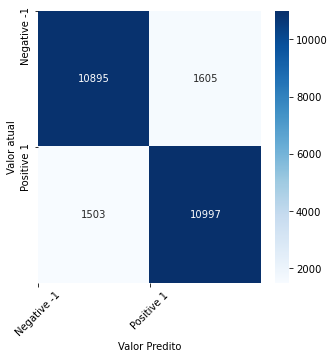

In [351]:
cm = confusion_matrix(test_data['sentiment'], model.predict(test_features))
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, cmap = plt.cm.Blues, fmt = '.8g')
classes = ['Negative -1', 'Positive 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Valor Predito')
plt.ylabel('Valor atual')
plt.show()

Avaliação dos modelos e técnicas:

    * CountVectorizer -> LogisticRegression: 86.00
    * TfidfVectorizer -> LogisticRegression: 87.57  
        
Modelo Escolhido : TfidfVectorizer -> LogisticRegression

### Salvando o Modelo

In [352]:
import joblib
joblib.dump(vectorizer, 'vectorizer.pkl', protocol=2)
joblib.dump(model, 'logistic_model.pkl', protocol=2)

['logistic_model.pkl']

### Novas avaliações

In [353]:
def pred_new(text):    
    text = vectorizer.transform([text])
    result = model.predict(text)
    final = '-1 Negative' if result[0] == -1 else '1 Positive'
    final = print(final)
    return final

In [354]:
pred_new('The movie is great')

1 Positive
